# Bibliotecas utilizadas

In [1]:
import datetime as dt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_datareader import data as web

# Definição dos ativos e do período de análise

In [2]:
#-- Serão consideradas as cotações históricas do ano de 2021
inicial = '01/01/2021'
final = '31/12/2021'

data_inicial = dt.datetime.strptime(inicial,'%d/%m/%Y')
data_final = dt.datetime.strptime(final,'%d/%m/%Y')

#-- Os ativos foram escolhidos de forma aleatória, a partir da composição do índice IBOV
lista_ativos = ['PETR4', 'JBSS3', 'SUZB3', 'B3SA3']

ativos = [n + '.SA' for n in lista_ativos]

# Obtenção do valor da taxa SELIC

In [3]:
#-- Será considerada a taxa SELIC vigente no último período de 2021

url = f'http://api.bcb.gov.br/dados/serie/bcdata.sgs.432/dados?formato=json&dataInicial={inicial}&dataFinal={final}'

taxa_selic_mensal = pd.read_json(url)

selic = taxa_selic_mensal.iloc[-1]['valor']/100

selic

0.0925

# Cotações históricas dos ativos

In [4]:
#--  As informações das cotações históricas serão obtidas no site Yahoo Finance

cotacoes = web.DataReader(ativos, 'yahoo', data_inicial, data_final)
cotacoes = cotacoes['Close']
hist = cotacoes.pct_change()
hist.head()

Symbols,PETR4.SA,JBSS3.SA,SUZB3.SA,B3SA3.SA
Date,,,,
2021-01-04,NaN,NaN,NaN,NaN
2021-01-05,0.039087,0.014524,-0.004583,0.001968
2021-01-06,0.001997,-0.008842,-0.018247,-0.016367
2021-01-07,0.029900,0.012319,0.085461,0.027953
2021-01-08,0.003871,0.023919,0.004641,0.014730


# Análise gráfica das cotações

<AxesSubplot:xlabel='Date'>

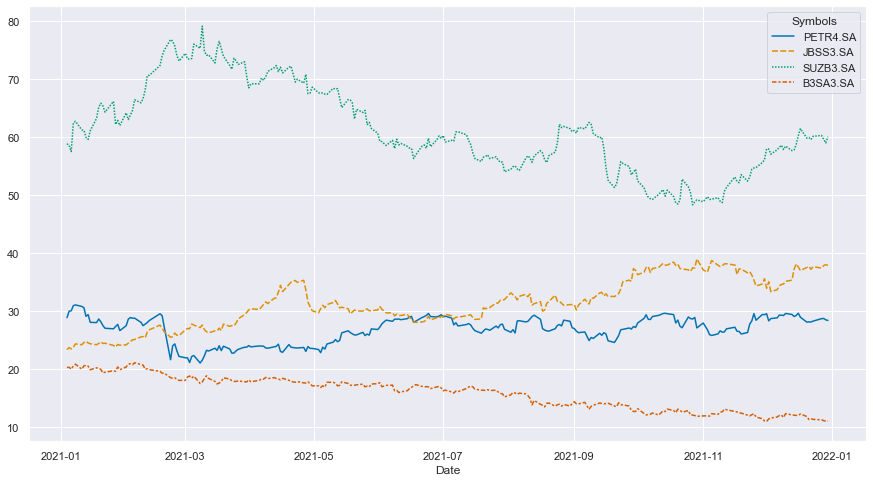

In [5]:
#-- Serão plotados os valores históricos dos ativos

sns.set(rc={'figure.figsize':(15,8)})

sns.lineplot(data=cotacoes, palette='colorblind')

# Retorno esperado e risco

In [6]:
#-- O retorno esperado de um ativo é a média das variações
#-- O risco de um ativo é o desvio-padrão da série
#-- Para transformar o retorno esperado diário em anual serão considerados 252 dias úteis

dict_ativos = {}

for ativo in ativos:
    retorno_esperado = hist[ativo].mean()
    risco = hist[ativo].std()
    
    dict_ativos[ativo] = {}
    dict_ativos[ativo]['Retorno Esperado Diário'] = retorno_esperado
    dict_ativos[ativo]['Risco'] = risco
    
variaveis = pd.DataFrame.from_dict(dict_ativos, orient='index')
variaveis['Retorno Esperado Anual'] = (variaveis['Retorno Esperado Diário'] + 1)**252 - 1
variaveis

,Retorno Esperado Diário,Risco,Retorno Esperado Anual
PETR4.SA,0.000331,0.027755,0.087073
JBSS3.SA,0.002163,0.019896,0.723730
SUZB3.SA,0.000292,0.020571,0.076327
B3SA3.SA,-0.002172,0.023222,-0.421791


# Matrizes de covariância e correlação

In [7]:
#-- A covariância será multiplicada por 252 devido ao número de dias úteis no ano

covariancia = hist.cov()*252
covariancia

Symbols,PETR4.SA,JBSS3.SA,SUZB3.SA,B3SA3.SA
Symbols,,,,
PETR4.SA,0.194132,0.025862,0.001997,0.045591
JBSS3.SA,0.025862,0.099753,0.013212,0.022506
SUZB3.SA,0.001997,0.013212,0.106638,0.008786
B3SA3.SA,0.045591,0.022506,0.008786,0.135893


In [8]:
hist.corr()

Symbols,PETR4.SA,JBSS3.SA,SUZB3.SA,B3SA3.SA
Symbols,,,,
PETR4.SA,1.000000,0.185844,0.013878,0.280693
JBSS3.SA,0.185844,1.000000,0.128097,0.193307
SUZB3.SA,0.013878,0.128097,1.000000,0.072986
B3SA3.SA,0.280693,0.193307,0.072986,1.000000


# Montagem de carteiras através do Método de Monte-Carlo

In [9]:
n_carteiras = 50000

dict_carteiras = {}

np.random.seed(100)

for n in range(n_carteiras):
    
    #-- Definição das participações de cada ativo da carteira de forma aleatória
    pesos = np.random.random_sample(len(lista_ativos))
    pesos = np.round(pesos / sum(pesos), 4)
    
    #-- Retorno e risco da carteira
    retorno_carteira = 0
    risco_carteira = 0
   
    for i in range(len(lista_ativos)):
        retorno_carteira += pesos[i] * variaveis.iloc[i]['Retorno Esperado Anual']
        
        for j in range(len(lista_ativos)):
            risco_carteira += pesos[i] * pesos[j] * covariancia.iloc[i][j]
    
    dict_carteiras['Carteira '+ str(n+1)] = {}
    dict_carteiras['Carteira '+ str(n+1)]['Retorno'] = retorno_carteira
    dict_carteiras['Carteira '+ str(n+1)]['Risco'] = risco_carteira ** 0.5
    dict_carteiras['Carteira '+ str(n+1)]['Sharpe'] = (retorno_carteira - selic) / risco_carteira ** 0.5

carteiras = pd.DataFrame.from_dict(dict_carteiras, orient='index')
carteiras.tail()

,Retorno,Risco,Sharpe
Carteira 49996,0.158177,0.223457,0.293915
Carteira 49997,0.278584,0.233127,0.798210
Carteira 49998,0.251276,0.239730,0.662311
Carteira 49999,0.230894,0.232001,0.596523
Carteira 50000,0.181367,0.211183,0.420804


# Dispersão das carteiras

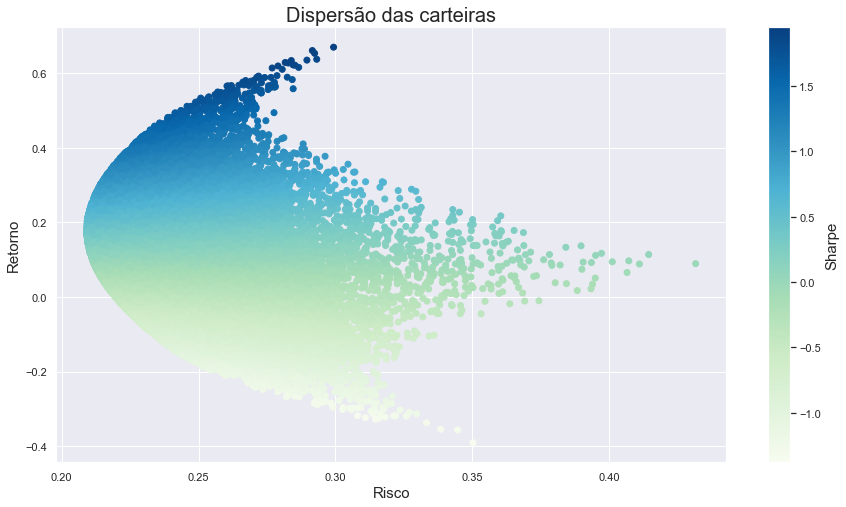

In [13]:
sns.set(rc={'figure.figsize':(15,8)})

colorbar, ax = plt.subplots()
points = ax.scatter(x = carteiras['Risco'], y = carteiras['Retorno'], 
                    c = carteiras['Sharpe'], cmap='GnBu')
plt.title('Dispersão das carteiras', size = 20)
plt.xlabel('Risco', size = 15)
plt.ylabel('Retorno', size = 15)
colorbar.colorbar(points).set_label(label = 'Sharpe',size=15)

# Definição da Fronteira Eficiente

In [11]:
intervalo = (carteiras.loc[carteiras['Retorno'].idxmax()]['Risco'] - carteiras['Risco'].min()) / 1000

limite_inferior = carteiras['Risco'].min()
limite_superior = limite_inferior + intervalo

lista_eficientes = []

retorno_maximo = 0 

while limite_inferior < carteiras.loc[carteiras['Retorno'].idxmax()]['Risco']:
    df = carteiras[(carteiras['Risco'] >= limite_inferior) & (carteiras['Risco'] <= limite_superior)]
    
    if not df.empty:
        retorno_max = df['Retorno'].max()
        if retorno_max > retorno_maximo:
            retorno_maximo = retorno_max
            maximo = df['Retorno'].idxmax()
            lista_eficientes.append(maximo)
    
    limite_inferior += intervalo
    limite_superior += intervalo
    
carteiras_eficientes = carteiras.loc[lista_eficientes]
carteiras_eficientes.head()

,Retorno,Risco,Sharpe
Carteira 34273,0.196609,0.209308,0.497398
Carteira 16227,0.201148,0.209384,0.518895
Carteira 48619,0.205906,0.209440,0.541470
Carteira 10201,0.215590,0.209653,0.587111
Carteira 45846,0.217851,0.209746,0.597634


# Fronteira Eficiente

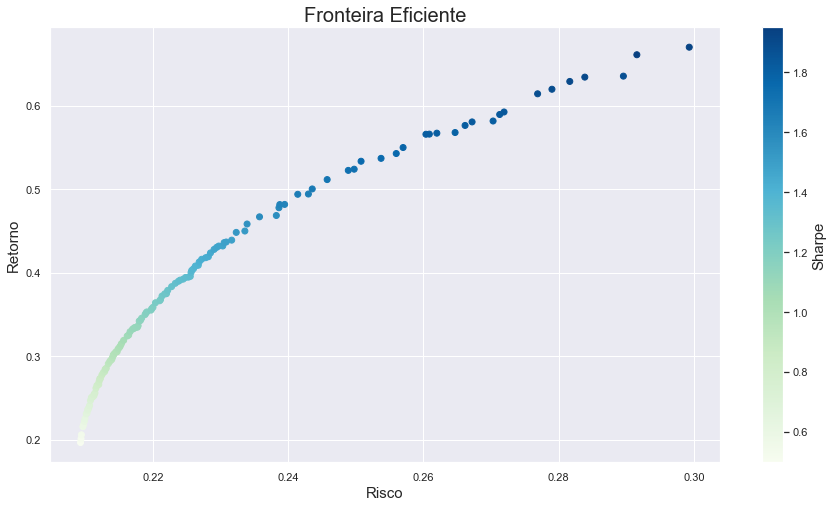

In [12]:
sns.set(rc={'figure.figsize':(15,8)})

colorbar, ax = plt.subplots()
points = ax.scatter(x = carteiras_eficientes.Risco, y = carteiras_eficientes.Retorno, 
                    c = carteiras_eficientes.Sharpe, cmap='GnBu')
plt.title('Fronteira Eficiente', size = 20)
plt.xlabel('Risco', size = 15)
plt.ylabel('Retorno', size = 15)
colorbar.colorbar(points).set_label(label = 'Sharpe',size=15)